In [1]:
import numpy
import tqdm
import pandas
import conntility
import json
import connalysis
import os

from matplotlib import pyplot as plt

from scipy import sparse
from scipy.spatial.distance import pdist, squareform

import nngraphmdl

## Load neuron locations

We load neuron locations in a central cube of the microns data.
Later, we wire up the neurons based on their locations.
This allows us to compare generated connectivity directly to microns.

In [80]:
# UPDATE PATH. WHERE CAN I FIND THE MICRONS CONNECTOME?
microns_connectome_prefix = "/home/reimann/Documents/data/microns/"

with open("../configs/attempt3_microns.json", "r") as fid:
    cfg = json.load(fid)

cfg["make_points"]["fn"] = os.path.join(microns_connectome_prefix, cfg["make_points"]["fn"])

pts, pts_sub, microns = nngraphmdl.points_from_microns(cfg["make_points"])
reference = microns.matrix > 0

64094


## Meta-model
We generate a number of matrices that determine how the model works out.

In [3]:
M12, M22, M21, M11 = nngraphmdl.make_matrices(pts, pts_sub, cfg["make_matrices"])

## Create stochastic connectome

In [7]:
N, stats_lvl1, stats_lvl2 = nngraphmdl.wire(M12, M22, M21, M11, pts, pts_sub, cfg["wire"])

## Comparison

### 1: How neuron degrees change with depth

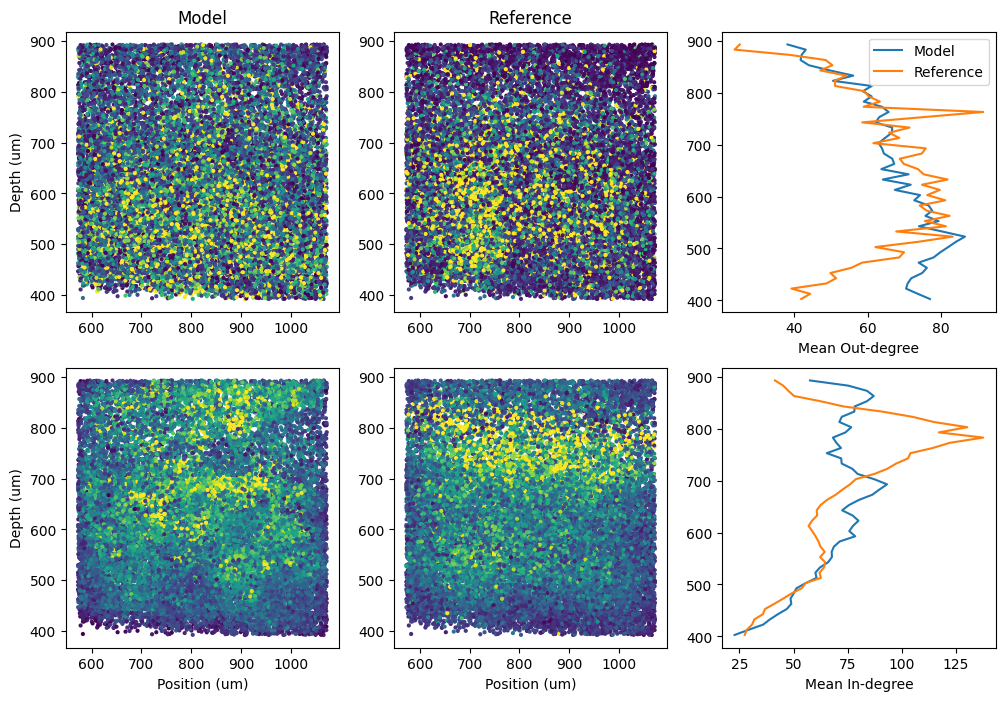

In [66]:
def plot_degrees(model, reference, nbins):
    ybins = numpy.linspace(pts[:, 1].min(), pts[:, 1].max() + 1E-3, nbins)
    df = pandas.DataFrame({"indegree_model": numpy.array(model.sum(axis=0))[0],
                           "indegree_ref": numpy.array(reference.sum(axis=0))[0],
                           "outdegree_model": numpy.array(model.sum(axis=1))[:, 0],
                           "outdegree_ref": numpy.array(reference.sum(axis=1))[:, 0],
                           "ybin": numpy.digitize(pts[:, 1], bins=ybins)})
    df_mn = df.groupby("ybin").mean()
    df_mn.index = ybins[df_mn.index]

    clim_out = (0.0, numpy.maximum(numpy.percentile(df["outdegree_model"], 90),
                                   numpy.percentile(df["outdegree_ref"], 90)))
    clim_in = (0.0, numpy.maximum(numpy.percentile(df["indegree_model"], 90),
                                   numpy.percentile(df["indegree_ref"], 90)))
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(2, 3, 1)
    ax.scatter(pts[:, 0], pts[:, 1], c=df["outdegree_model"], s=4, clim=clim_out)
    ax.set_ylabel("Depth (um)")
    ax.set_title("Model")

    ax = fig.add_subplot(2, 3, 2)
    ax.scatter(pts[:, 0], pts[:, 1], c=df["outdegree_ref"], s=4, clim=clim_out)
    ax.set_title("Reference")
    
    ax = fig.add_subplot(2, 3, 3)
    ax.plot(df_mn["outdegree_model"], df_mn.index, label="Model")
    ax.plot(df_mn["outdegree_ref"], df_mn.index, label="Reference")
    ax.set_xlabel("Mean Out-degree")
    plt.legend()
    
    ax = fig.add_subplot(2, 3, 4)
    ax.scatter(pts[:, 0], pts[:, 1], c=df["indegree_model"], s=4, clim=clim_out)
    ax.set_ylabel("Depth (um)")
    ax.set_xlabel("Position (um)")

    ax = fig.add_subplot(2, 3, 5)
    ax.scatter(pts[:, 0], pts[:, 1], c=df["indegree_ref"], s=4, clim=clim_out)
    ax.set_xlabel("Position (um)")
    
    ax = fig.add_subplot(2, 3, 6)
    ax.plot(df_mn["indegree_model"], df_mn.index, label="Model")
    ax.plot(df_mn["indegree_ref"], df_mn.index, label="Reference")
    ax.set_xlabel("Mean In-degree")
    return df

df_degrees = plot_degrees(N, reference, 51)


### 2: Distributions of in/out-degrees

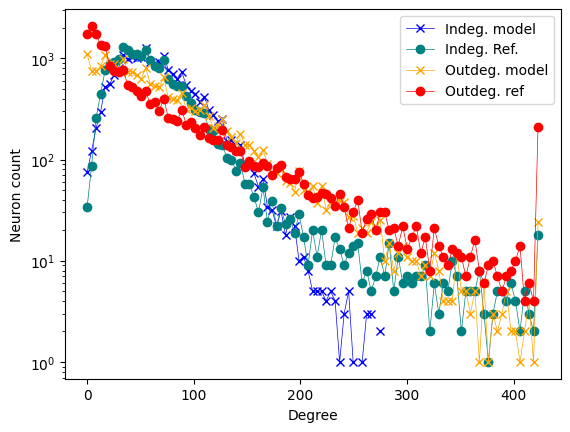

In [63]:
nbins = 101

_cols = df_degrees.columns[:-1]
mx_degree = df_degrees[_cols].apply(lambda _x: numpy.percentile(_x, 99)).max()
deg_bins = numpy.linspace(0, mx_degree, nbins)
df_dgtz = df_degrees[_cols].apply(lambda _x: numpy.digitize(_x, bins=deg_bins) - 1)
df_count = df_dgtz.apply(lambda _x: _x.value_counts().sort_index())

fig = plt.figure()

ax = fig.gca()

ax.plot(deg_bins[df_count.index], df_count["indegree_model"], marker='x', lw=0.5, color="blue", label="Indeg. model")
ax.plot(deg_bins[df_count.index], df_count["indegree_ref"], marker='o', lw=0.5, color="teal", label="Indeg. Ref.")
ax.plot(deg_bins[df_count.index], df_count["outdegree_model"], marker='x', lw=0.5, color="orange", label="Outdeg. model")
ax.plot(deg_bins[df_count.index], df_count["outdegree_ref"], marker='o', lw=0.5, color="red", label="Outdeg. ref")

ax.set_xlabel("Degree")
ax.set_ylabel("Neuron count")
ax.set_yscale("log")
plt.legend()

### 3: Connection probability against distance

/tmp/ipykernel_1011/1893019468.py:12: RuntimeWarning: invalid value encountered in divide
  ax.plot(dbins[:-1], H_con_mdl / H_all, color=[0.35, 0.7, 0.35], label="Model")
/tmp/ipykernel_1011/1893019468.py:13: RuntimeWarning: invalid value encountered in divide
  ax.plot(dbins[:-1], H_con_ref / H_all, color=[0.2, 0.9, 0.2], label="Reference")


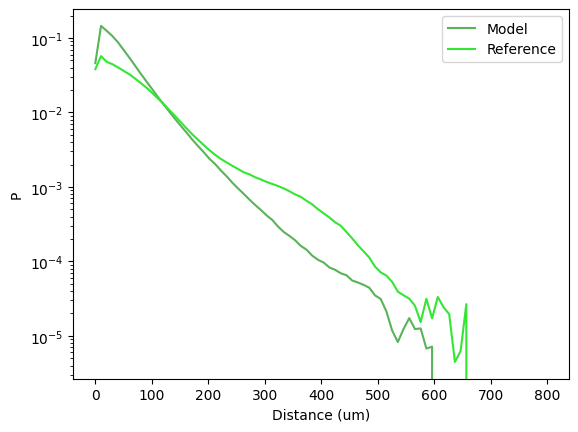

In [51]:
dbins = numpy.linspace(0, 1000, 100)

D = squareform(pdist(pts))
Ncoo = N.tocoo(); refcoo = reference.tocoo()

H_all = numpy.histogram(D.flatten(), bins=dbins)[0]
H_con_mdl = numpy.histogram(D[Ncoo.row, Ncoo.col], bins=dbins)[0]
H_con_ref = numpy.histogram(D[refcoo.row, refcoo.col], bins=dbins)[0]

fig = plt.figure()
ax = fig.gca()
ax.plot(dbins[:-1], H_con_mdl / H_all, color=[0.35, 0.7, 0.35], label="Model")
ax.plot(dbins[:-1], H_con_ref / H_all, color=[0.2, 0.9, 0.2], label="Reference")
plt.gca().set_yscale("log")
ax.set_xlabel("Distance (um)"); ax.set_ylabel("P")
plt.legend()

### 4: Simplex counts and simplex counts in controls

In [57]:
import connalysis

def simplex_counts_and_controls(matrix):
    O = matrix.tocsc()
    keys = []
    res = []

    _N = connalysis.randomization.ER_shuffle(O)
    keys.append("ER")
    res.append(connalysis.network.simplex_counts(_N.astype(bool), max_dim=10))

    _N = connalysis.randomization.configuration_model(O)
    keys.append("Config. model")
    res.append(connalysis.network.simplex_counts(_N.astype(bool), max_dim=10))
    
    _N = connalysis.randomization.bishuffled_model(O)
    keys.append("Bishuffled model")
    res.append(connalysis.network.simplex_counts(_N.astype(bool), max_dim=10))

    keys.append("Original")
    res.append(connalysis.network.simplex_counts(O, max_dim=10))
    return pandas.concat(res, axis=0, keys=keys)

smplx_model = simplex_counts_and_controls(N).unstack(fill_value=0)
smplx_ref = simplex_counts_and_controls(reference).unstack(fill_value=0)

 2024-10-28 15:03:09,080: No seed among keyword arguments
 2024-10-28 15:03:09,546: Shuffle 1424791 edges following Erdos-Renyi
/home/reimann/venvs/bpsnap/lib/python3.8/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
 2024-10-28 15:03:54,788: No seed among keyword arguments
 2024-10-28 15:03:55,170: Shuffle 1366115 edges following Erdos-Renyi
/home/reimann/venvs/bpsnap/lib/python3.8/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Text(0, 0.5, 'Count')

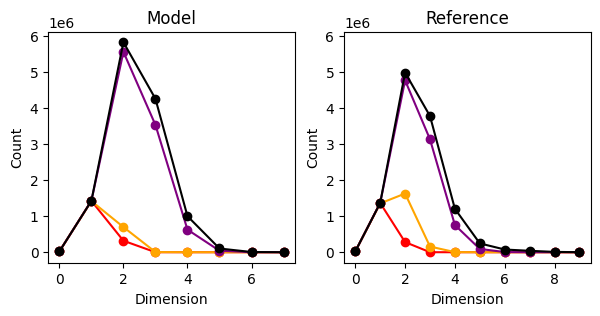

In [64]:
fig = plt.figure(figsize=(7, 3))

cols = {"Original": "black", "ER": "red", "Config. model": "orange", "Bishuffled model": "purple"}

ax = fig.add_subplot(1, 2, 1)
for mdl in smplx_model.index:
    ax.plot(smplx_model.loc[mdl], label=mdl, color=cols[mdl], marker='o')
ax.set_title("Model")
ax.set_xlabel("Dimension"); ax.set_ylabel("Count")

ax = fig.add_subplot(1, 2, 2, sharey=ax)
for mdl in smplx_ref.index:
    ax.plot(smplx_ref.loc[mdl], label=mdl, color=cols[mdl], marker='o')
ax.set_title("Reference")
ax.set_xlabel("Dimension"); ax.set_ylabel("Count")

### 5: How Connectivity increases when the nearest neighbor is connected
Hint: Similar to what we did for the human model project.

/tmp/ipykernel_1011/2509622286.py:26: RuntimeWarning: invalid value encountered in divide
  P_con_mdl = H_con_mdl / H_all
/tmp/ipykernel_1011/2509622286.py:24: RuntimeWarning: invalid value encountered in divide
  return H_x_con / H_x_all
/tmp/ipykernel_1011/2509622286.py:30: RuntimeWarning: invalid value encountered in divide
  P_con_ref = H_con_ref / H_all
/tmp/ipykernel_1011/2509622286.py:39: RuntimeWarning: invalid value encountered in divide
  plt.plot(dbins[:-1], (P_x_con_ref_e - P_con_ref) / (P_x_con_ref_e + P_con_ref),
/tmp/ipykernel_1011/2509622286.py:42: RuntimeWarning: invalid value encountered in divide
  plt.plot(dbins[:-1], (P_x_con_mdl_a - P_con_mdl) / (P_x_con_mdl_a + P_con_mdl),


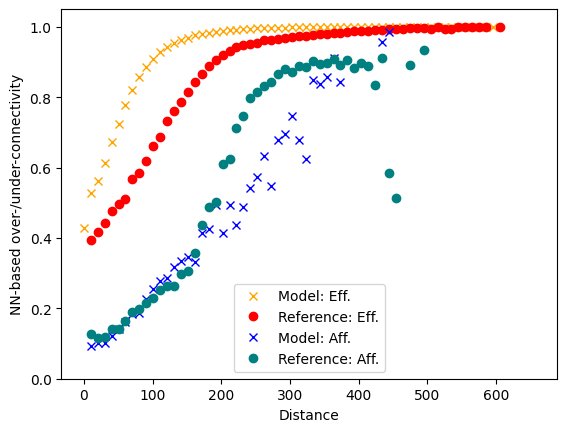

In [77]:
from scipy.spatial import KDTree

def dist_and_nn_analysis(matrix, pts, D, dbins, direction="efferent"):
    if direction == "efferent":
        O = matrix.tocsr()
    elif direction == "afferent":
        O = matrix.tocsc()

    kd = KDTree(pts)
    _, idx = kd.query(pts, numpy.arange(2, 3))
    idx = idx[:, 0]

    dists_x_all = []; dists_x_con = []
    for i, ab in enumerate(zip(O.indptr[:-1], O.indptr[1:])):
        a, b = ab
        __idx = O.indices[a:b]
        nn_idx = idx[__idx]  # indices of neurons that have their nearest neighbor being connected
        is_con = numpy.in1d(nn_idx, __idx)
        _d = D[i, nn_idx]
        dists_x_all.extend(_d)  # distances of neurons that have their nn connected
        dists_x_con.extend(_d[is_con])  # distances of neurons that have their nn connected and themselves connected
    H_x_all = numpy.histogram(dists_x_all, bins=dbins)[0]
    H_x_con = numpy.histogram(dists_x_con, bins=dbins)[0]
    return H_x_con / H_x_all

P_con_mdl = H_con_mdl / H_all
P_x_con_mdl_e = dist_and_nn_analysis(N, pts, D, dbins)
P_x_con_mdl_a = dist_and_nn_analysis(N, pts, D, dbins, direction="afferent")

P_con_ref = H_con_ref / H_all
P_x_con_ref_e = dist_and_nn_analysis(reference, pts, D, dbins)
P_x_con_ref_a = dist_and_nn_analysis(reference, pts, D, dbins, direction="afferent")

fig = plt.figure()
ax = fig.gca()

plt.plot(dbins[:-1], (P_x_con_mdl_e - P_con_mdl) / (P_x_con_mdl_e + P_con_mdl),
         color="orange", marker="x", ls="None", label="Model: Eff.")
plt.plot(dbins[:-1], (P_x_con_ref_e - P_con_ref) / (P_x_con_ref_e + P_con_ref),
         color="red", marker="o", ls="None", label="Reference: Eff.")

plt.plot(dbins[:-1], (P_x_con_mdl_a - P_con_mdl) / (P_x_con_mdl_a + P_con_mdl),
         color="blue", marker="x", ls="None", label="Model: Aff.")
plt.plot(dbins[:-1], (P_x_con_ref_a - P_con_ref) / (P_x_con_ref_a + P_con_ref),
         color="teal", marker="o", ls="None", label="Reference: Aff.")
ax.set_xlabel("Distance")
ax.set_ylabel("NN-based over-/under-connectivity")
ax.set_ylim([0, 1.05])
plt.legend()